In [1]:
# Import basic libraries
import copy # copy variables
import os   # manage paths
from collections import defaultdict
from tabulate import tabulate
import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars
import atlasopenmagic as atom # ATLAS Open Data package
import numpy as np
import pandas as pd # dataframes
import torch
import torch.nn as nn
from torch import Tensor
from scipy.fftpack import dct, idct

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import skew, kurtosis, entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon
from statsmodels.distributions.empirical_distribution import ECDF
pd.options.display.float_format = '{:,.6f}'.format

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

# Base output directories (match your Bash script)
base_compressed_real = "/eos/user/y/yolanney/compressed_files/real"
base_compressed_sim  = "/eos/user/y/yolanney/compressed_files/sim"

# Full original paths
real_uncompressed = [
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1",
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6482/data23_13p6TeV.00456749.physics_Main.deriv.DAOD_PHYSLITE.r15774_p6304_p6482/DAOD_PHYSLITE.41588921._000002.pool.root.1"
]

sim_uncompressed = [
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6490/mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_r13146_p6490/DAOD_PHYSLITE.41651753._000007.pool.root.1",
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6491/mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r15540_r15516_p6491/DAOD_PHYSLITE.41633384._000941.pool.root.1"
]

filename = "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1"
compressed_filename = "/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41578717._000256.pool.root_dl10_compressed.root"
def make_compressed_path(original_path, category, level_tag="dl10"):
    base = base_compressed_real if category == "real" else base_compressed_sim
    filename = os.path.basename(original_path)

    # Strip final `.1` only if present
    if filename.endswith(".1"):
        filename = filename[:-2]  # removes the last 2 chars: `.1`

    compressed_filename = f"{filename}_{level_tag}_compressed.root"
    return os.path.join(base, compressed_filename)

# def safe_latex(text):
#     return text.encode("ascii", errors="ignore").decode()

# Function to run comparison
def create_file_pairs(uncompressed_files, base_compressed_dir, data_category):
    """Create pairs of uncompressed and compressed file paths.
    
    Args:
        uncompressed_files: List of uncompressed file paths
        base_compressed_dir: Base directory for compressed files
        data_category: Category label ('Real' or 'Sim')
        
    Returns:
        List of tuples (uncompressed_path, compressed_path, category_label)
    """
    pairs = []
    for path in uncompressed_files:
        comp = make_compressed_path(path, data_category.lower())  # 'Real' -> 'real', 'Sim' -> 'sim'
        pairs.append((path, comp, data_category))
    return pairs
real_pairs = create_file_pairs(real_uncompressed, base_compressed_real, "Real")
sim_pairs = create_file_pairs(sim_uncompressed, base_compressed_sim, "Sim")
print("Real pairs:", real_pairs)

# === Load Data ===
def load_variable(orig_path, comp_path, varname):
    tree_orig = uproot.open({orig_path: "CollectionTree"})
    tree_comp = uproot.open({comp_path: "CollectionTree"})

    x_true = ak.flatten(tree_orig[varname].array()).to_numpy()
    x_recon = ak.flatten(tree_comp[varname].array()).to_numpy()

    # Mask invalid values
    mask = (np.abs(x_true) > 0) & np.isfinite(x_true) & np.isfinite(x_recon)
    return x_true[mask], x_recon[mask]

index = 0
# === Run the whole thing ===
orig_path = real_pairs[index][0]
comp_path = real_pairs[index][1]
branch = "AnalysisElectronsAuxDyn"
varname = "pt"  # or eta, phi, etc.

x_true, x_recon = load_variable(orig_path, comp_path, branch + "." + varname)

Real pairs: [('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1', '/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41578717._000256.pool.root_dl10_compressed.root', 'Real'), ('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6482/data23_13p6TeV.00456749.physics_Main.deriv.DAOD_PHYSLITE.r15774_p6304_p6482/DAOD_PHYSLITE.41588921._000002.pool.root.1', '/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41588921._000002.pool.root_dl10_compressed.root', 'Real')]


In [2]:
# Swish activation
class Swish(nn.Module):
    def forward(self, x: Tensor) -> Tensor: 
        return x * torch.sigmoid(x)

# Symmetric FlowMatching MLP with optional conditioning
class MLP(nn.Module):
    def __init__(self, input_dim: int = 1, output_dim: int = 1, time_dim: int = 1,
                 hidden_dim: int = 128, cond_dim: int = 0, symmetric: bool = False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.cond_dim = cond_dim
        self.symmetric = symmetric

        total_input_dim = self.input_dim + self.time_dim + self.cond_dim

        self.base_net = nn.Sequential(
            nn.Linear(total_input_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, self.output_dim),
        )

    def forward(self, x: Tensor, t: Tensor, cond: Tensor = None) -> Tensor:
        x = x.view(-1, self.input_dim)
        t = t.view(-1, self.time_dim).float()

        # Expand t to match input if needed
        if t.shape[1] != x.shape[1] and t.shape[1] == 1:
            t = t.expand(-1, x.shape[1])

        if cond is not None:
            cond = cond.view(-1, self.cond_dim)
            xt = torch.cat([x, t, cond], dim=1)
            xt_neg = torch.cat([-x, t, cond], dim=1) if self.symmetric else None
        else:
            xt = torch.cat([x, t], dim=1)
            xt_neg = torch.cat([-x, t], dim=1) if self.symmetric else None

        v_pos = self.base_net(xt)

        if self.symmetric:
            v_neg = self.base_net(xt_neg)
            return 0.5 * (v_pos - v_neg)

        return v_pos


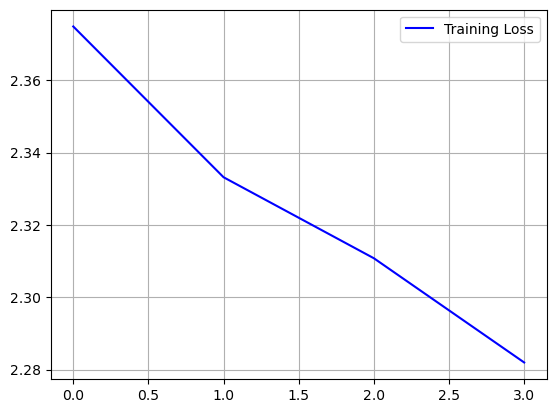

Epoch 003 | Loss: 2.281981


KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt
from IPython.display import clear_output  # For Jupyter notebooks
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize lists to store loss values
loss_history = []
epoch_history = []

# Create figure for plotting
plt.figure(figsize=(10, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

residual = x_true - x_recon

x0 = np.log10(np.abs(x_true) + 1e-12).astype(np.float32)
x1 = np.sign(residual) * np.log10(np.abs(residual) + 1e-12).astype(np.float32)

x0_tensor = torch.tensor(x0).unsqueeze(1)
x1_tensor = torch.tensor(x1).unsqueeze(1)

dataset = TensorDataset(x0_tensor, x1_tensor)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

# === Model ===
vf = MLP(input_dim=1, output_dim=1, time_dim=1, hidden_dim=128).to(device)

# === Optimizer ===
optimizer = optim.Adam(vf.parameters(), lr=1e-3)

# === Training Loop ===
path = AffineProbPath(scheduler=CondOTScheduler())  # flow_matching path
loss_fn = torch.nn.MSELoss()

for epoch in range(50):
    total_loss = 0
    for _, log_res in dataloader:
        x_0 = torch.randn_like(log_res).to(device)

        t = torch.rand(x_0.shape[0], device=x_0.device)
        path_sample = path.sample(t=t, x_0=x_0, x_1=log_res)

        # Forward pass
        loss = loss_fn(vf(path_sample.x_t, path_sample.t), path_sample.dx_t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    epoch_history.append(epoch)
    
    # Update plot
    clear_output(wait=True)  # Clear previous output (for Jupyter notebooks)
    plt.plot(epoch_history, loss_history, 'b-', label='Training Loss')
    plt.legend()
    plt.grid(True)
    plt.pause(0.1)  # Pause to update the plot
    
    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

# Keep the plot open at the end
plt.show()

In [4]:
x_0.min(), x_0.max()

(tensor(-3.2618), tensor(3.6231))

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_log_residual_contour(x_true, residual, gmm=None, varname="pt"):
    # Calculate residuals and transform to log scale
    log_x_true = np.log10(np.abs(x_true) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    
    # Create grid for contours
    x_min, x_max = np.percentile(log_x_true, [1, 99.9])
    y_min, y_max = np.percentile(log_residual, [1, 99.9])
    
    # Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        log_x_true, log_residual, 
        bins=100, 
        range=[[x_min, x_max], [y_min, y_max]],
        density=True
    )
    
    # Smooth the histogram
    hist_smooth = gaussian_filter1d(hist, sigma=1)
    
    # Create meshgrid for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    xx, yy = np.meshgrid(x_centers, y_centers)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Contour plot of actual data
    levels = np.linspace(0, hist_smooth.max(), 50)
    cs = plt.contourf(xx, yy, hist_smooth.T, levels=levels, cmap='viridis', alpha=0.7)
    plt.colorbar(cs, label='Density')
    
    # Plot GMM components if provided
    if gmm is not None:
        # Create evaluation grid
        grid = np.column_stack([xx.ravel(), yy.ravel()])
        scores = gmm.score_samples(grid)
        scores = np.exp(scores).reshape(xx.shape)
        
        # Plot GMM contours
        gmm_levels = np.linspace(0, scores.max(), 10)
        plt.contour(xx, yy, scores, levels=gmm_levels, colors='red', linewidths=1, alpha=0.7)
        
        # Plot component means
        plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
                   c='red', s=100, marker='x', label='GMM Means')
        plt.scatter(gmm.means_[:, 0], -gmm.means_[:, 1], 
                   c='blue', s=100, marker='o', label='Mirrored Means')
    
    # Formatting
    plt.title(f'Log-Scale Residual vs True Value: {varname}')
    plt.xlabel('log10(|True Value|)')
    plt.ylabel('Signed log10(|Residual|)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add marginal distributions
    ax = plt.gca()
    ax_top = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_right = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    
    # Top marginal (log|x_true| distribution)
    ax_top.hist(log_x_true, bins=x_centers, density=True, color='gray', alpha=0.7)
    ax_top.set_yticks([])
    
    # Right marginal (log|residual| distribution)
    ax_right.hist(log_residual, bins=y_centers, density=True, 
                 orientation='horizontal', color='gray', alpha=0.7)
    ax_right.set_xticks([])
    
    plt.tight_layout()
    plt.show()

class CFGScaledModel(ModelWrapper):
    def __init__(self, model: nn.Module, conditioning=False):
        super().__init__(model)
        self.model = model
        self.conditioning = conditioning

    def forward(
        self, x, t, cond: torch.Tensor = None
    ):
        if t.ndim == 0:  # scalar
            t = t.expand(x.shape[0])  # make it (batch_size,)

        if self.conditioning:
            with torch.amp.autocast('cuda'), torch.no_grad():
                    # print(t.shape)
                    result = self.model(x, t, cond=cond)

        else:
            with torch.amp.autocast('cuda'), torch.no_grad():
                # print(t.shape)
                result = self.model(x, t, )
        return result.to(dtype=torch.float32)

    def reset_nfe_counter(self) -> None:
        self.nfe_counter = 0

    def get_nfe(self) -> int:
        return self.nfe_counter

T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)
x_0 = torch.randn_like(log_res).to(device)
print("x_0 shape:", x_0.shape)
cfg_scaled_model = CFGScaledModel(model=vf).to(device)
solver = ODESolver(velocity_model=cfg_scaled_model)
residual = solver.sample(
        time_grid=T,
        x_init=x_0,
        method='heun2',
        return_intermediates=False,
        atol=1e-5,
        rtol=1e-5,
        step_size=None,
        cond=None,
    )


x_0 shape: torch.Size([1827, 1])


TypeError: CFGScaledModel.forward() got an unexpected keyword argument 'label'

In [6]:
x_0.shape, residual.shape
# log_x_true = np.log10(np.abs(x_true) + 1e-12)

(torch.Size([1827, 1]), torch.Size([1827, 1]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


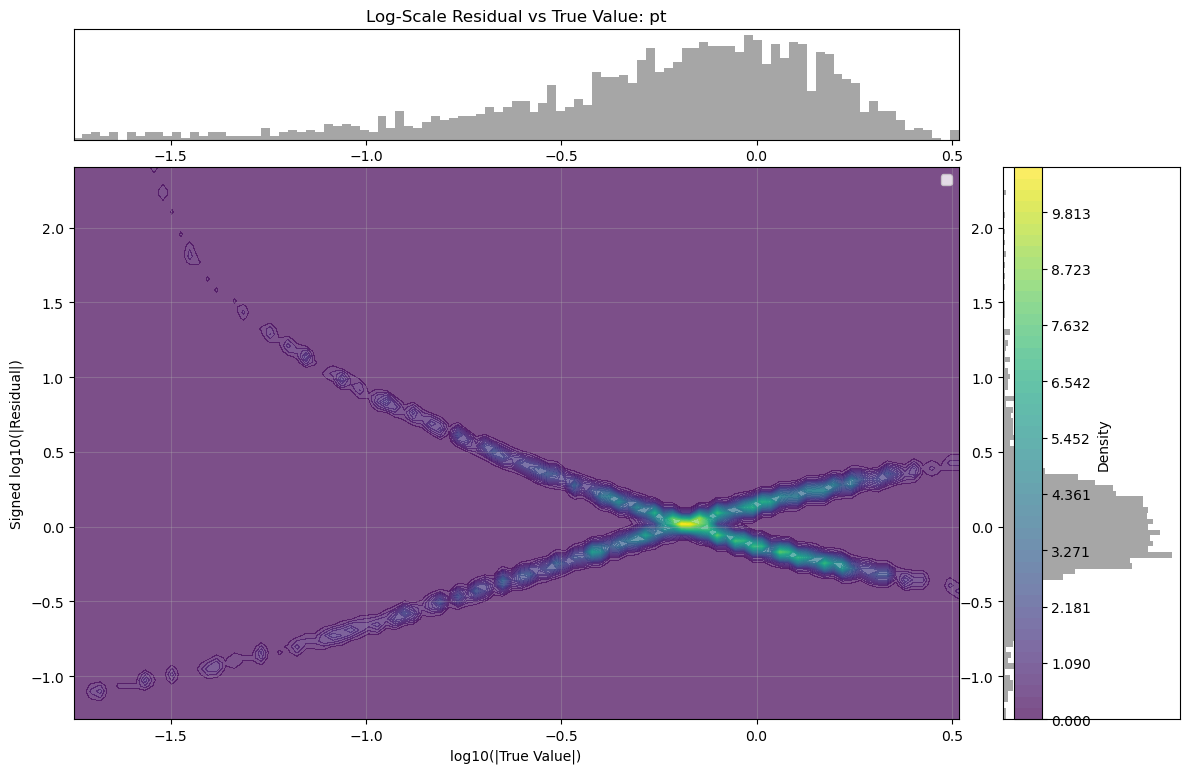

In [7]:
plot_log_residual_contour(x_0.squeeze(), residual.squeeze(), None, varname)


(100, 500)


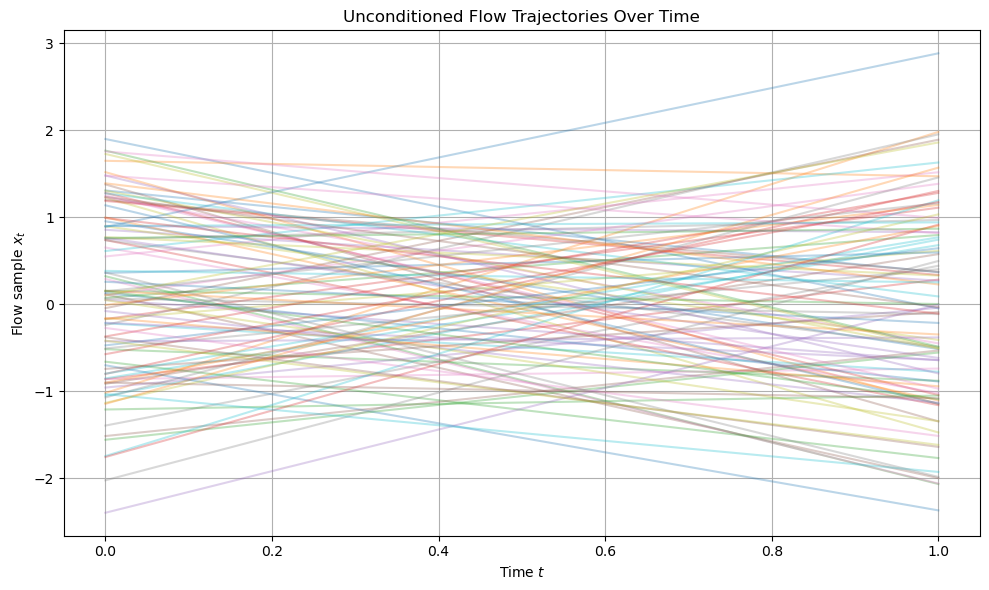

In [8]:
# Prepare data (same as training)
n_points = 500
x1 = torch.tensor(x1[:n_points], dtype=torch.float32).unsqueeze(1).to(device)  # log residuals
x0 = torch.randn_like(x1).to(device)  # initial noise

vf.eval()  # turn off dropout, etc.
path = AffineProbPath(scheduler=CondOTScheduler())

# Timesteps from 0 to 1
timesteps = torch.linspace(0, 1, 100).to(device)

# Collect flow samples
flow_traj = []
with torch.no_grad():
    for t in timesteps:
        t_batch = torch.full((n_points,), t, device=device)
        path_sample = path.sample(t=t_batch, x_0=x0, x_1=x1)

        flow_traj.append(path_sample.x_t.cpu().numpy())  # shape [B, 1]

flow_traj = np.stack(flow_traj, axis=0).squeeze(-1)  # [T, B]
print(flow_traj.shape)
plt.figure(figsize=(10, 6))
for i in range(min(n_points, 100)):  # plot 100 sample lines max
    plt.plot(timesteps.cpu(), flow_traj[:, i], alpha=0.3)

plt.xlabel("Time $t$")
plt.ylabel("Flow sample $x_t$")
plt.title("Unconditioned Flow Trajectories Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# Second Experiment - Conditioning and Normalising

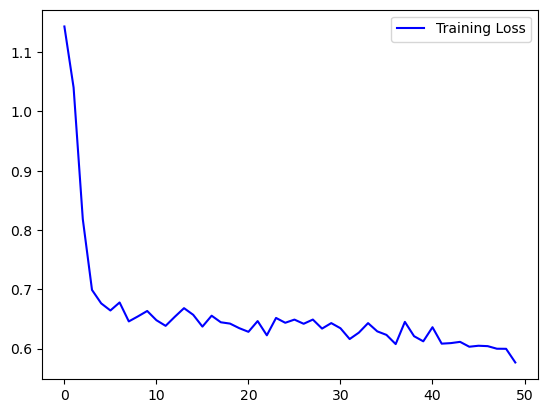

Epoch 049 | Loss: 0.576526


In [24]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from flow_matching.path import AffineProbPath
from flow_matching.path.scheduler import CondOTScheduler
import matplotlib.pyplot as plt
from IPython.display import clear_output  # For Jupyter notebooks

# === Prepare Data ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize plot
plt.figure(figsize=(10, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
loss_history = []

# Assume x_true and x_recon are available as NumPy arrays
residual = x_true - x_recon

# Log-space transform
x0 = np.log10(np.abs(x_true) + 1e-12).astype(np.float32)
x1 = np.sign(residual) * np.log10(np.abs(residual) + 1e-12).astype(np.float32)

# Compute min/max for normalization
x0_min, x0_max = x0.min(), x0.max()
x1_min, x1_max = x1.min(), x1.max()

# Normalize to [-1, 1]
x0_norm = (x0 - x0_min) / (x0_max - x0_min) * 2 - 1
x1_norm = (x1 - x1_min) / (x1_max - x1_min) * 2 - 1

# Convert to tensors
x0_tensor = torch.tensor(x0_norm).unsqueeze(1)
x1_tensor = torch.tensor(x1_norm).unsqueeze(1)

dataset = TensorDataset(x0_tensor, x1_tensor)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

# === Model ===
vf = MLP(input_dim=1, output_dim=1, time_dim=1, cond_dim=1, hidden_dim=128).to(device)

# === Optimizer ===
optimizer = optim.Adam(vf.parameters(), lr=1e-3)

# === Path & Loss ===
path = AffineProbPath(scheduler=CondOTScheduler())
loss_fn = nn.MSELoss()

# === Training Loop ===
for epoch in range(50):
    total_loss = 0
    for compressed, log_res in dataloader:
        compressed = compressed.to(device)
        log_res = log_res.to(device)

        # Sample random noise for starting point
        x_0 = torch.randn_like(log_res)

        # Sample t and path
        t = torch.rand(x_0.shape[0], device=device)
        path_sample = path.sample(t=t, x_0=x_0, x_1=log_res)

        # Forward pass
        loss = loss_fn(vf(path_sample.x_t, path_sample.t, cond=compressed), path_sample.dx_t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    
    # Update plot
    clear_output(wait=True)  # For Jupyter notebooks
    plt.plot(loss_history, 'b-', label='Training Loss')
    plt.legend()
    plt.pause(0.1)  # Pause to update the plot
    
    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

# Keep the plot open at the end
plt.show()

# For denormalizing later:
def denormalize(x_norm, x_min, x_max):
    return (x_norm + 1) / 2 * (x_max - x_min) + x_min

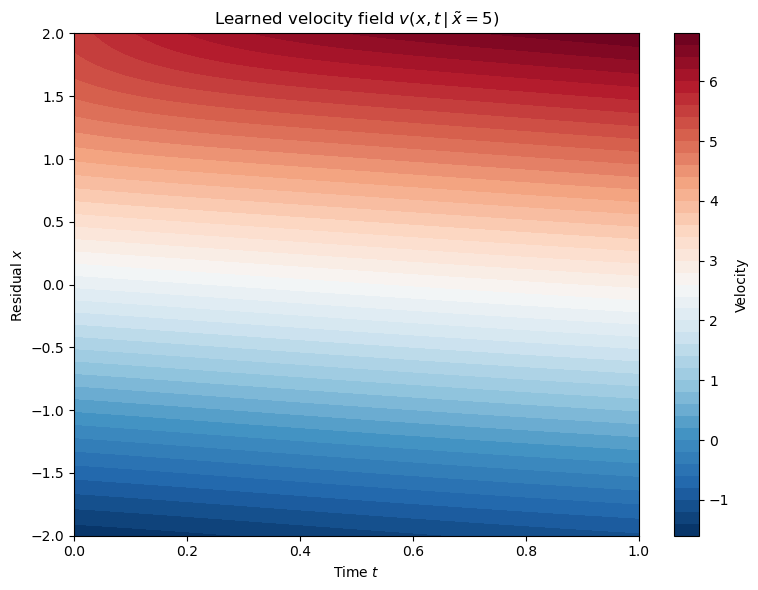

In [26]:
# Set model to eval mode
vf.eval()

# Define the grid
x_vals = torch.linspace(-2, 2, 100).view(-1, 1)
t_vals = torch.linspace(0, 1, 100).view(1, -1)
x_grid, t_grid = torch.meshgrid(x_vals.squeeze(), t_vals.squeeze(), indexing='ij')

# Flatten the grid for input
x_flat = x_grid.reshape(-1, 1).to(device)
t_flat = t_grid.reshape(-1, 1).to(device)

# Choose a fixed conditioning value (e.g., log10(|compressed|))
fixed_cond = torch.full_like(x_flat, fill_value=5.0).to(device)

# Predict velocity
with torch.no_grad():
    v_pred = vf(x_flat, t_flat, cond=fixed_cond).cpu().numpy()

# Reshape velocity to grid shape
v_field = v_pred.reshape(x_grid.shape)

# === Plotting ===
plt.figure(figsize=(8, 6))
plt.contourf(t_grid, x_grid, v_field, levels=50, cmap="RdBu_r")
plt.colorbar(label="Velocity")
plt.xlabel("Time $t$")
plt.ylabel("Residual $x$")
plt.title("Learned velocity field $v(x, t \\,|\\, \\tilde{x}=5)$")
plt.tight_layout()
plt.show()


/cvmfs/sft.cern.ch/lcg/views/LCG_106/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


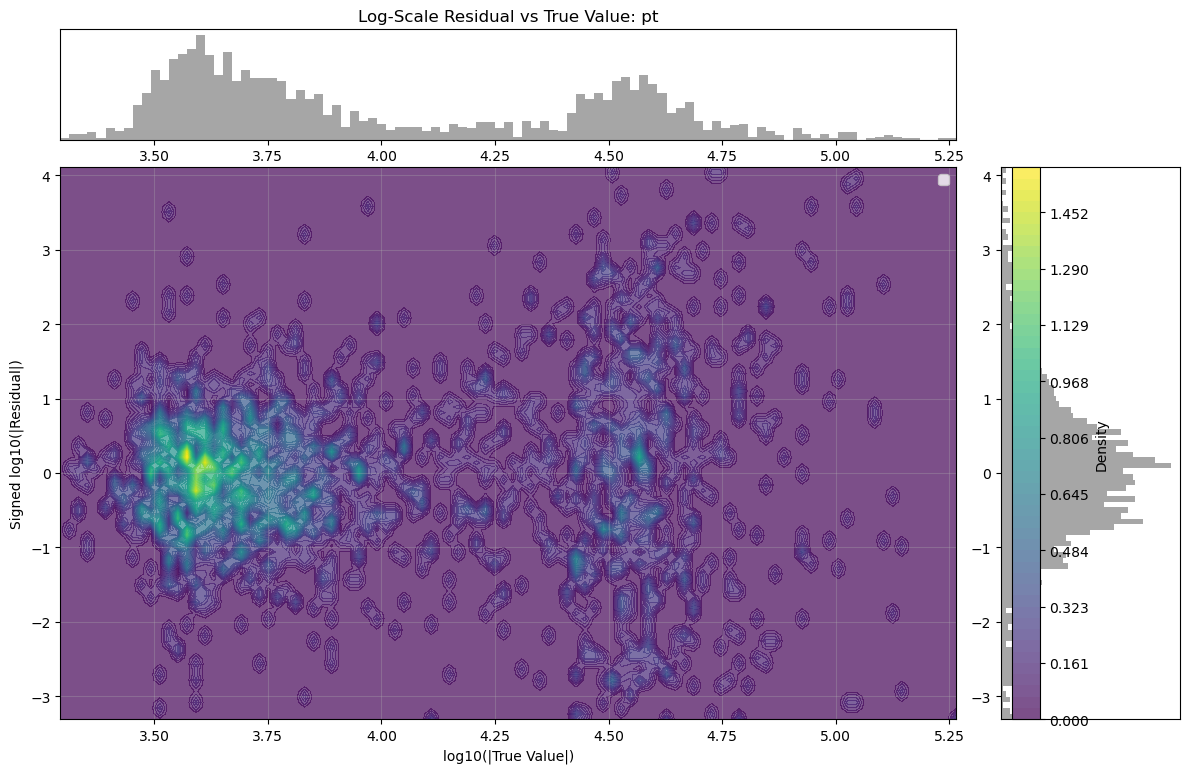

In [29]:
vf.eval()

# === Setup ===
n_samples = 10_000
T = torch.linspace(0, 1, 50).to(device)  # time grid
tilde_x = compressed[:n_samples].to(device)  # normalized log-space compressed inputs
x0 = torch.randn_like(tilde_x).to(device)  # initial noise

# === Solve with ODESolver ===
cfg_scaled_model = CFGScaledModel(model=vf, conditioning=True).to(device)
solver = ODESolver(velocity_model=cfg_scaled_model)

residual_log_norm = solver.sample(
    time_grid=T,
    x_init=x0,
    method='heun2',
    return_intermediates=False,
    atol=1e-5,
    rtol=1e-5,
    step_size=None,
    cond=tilde_x  # conditional input
)

# === Denormalize ===
log_residual = residual_log_norm.squeeze().detach().cpu().numpy()
tilde_x_np = tilde_x.squeeze().detach().cpu().numpy()

tilde_x_log = denormalize(tilde_x_np, x0_min, x0_max)
log_residual_denorm = denormalize(log_residual, x1_min, x1_max)

# === Convert from log to real ===
tilde_x_real = 10 ** tilde_x_log
residual_real = np.sign(log_residual_denorm) * 10 ** np.abs(log_residual_denorm)

# === Plot ===
plot_log_residual_contour(tilde_x_real, residual_real, None, varname)
